# Studying climate distance on artificial data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

## 2D simulation

In [3]:
##################################################
#            generate height environment         #
#
# all environments are part of a NxN box
# the max height of the hill is always 1
#
# horizontal works best, others have been removed
##################################################

def environment_2d(N = 50, mountain_type = 'horizontal'):
    if mountain_type == 'horizontal':
        height = np.zeros([N,N])
        for i in range(N):
            for j in range(N):
                height[i,j] = np.max([1-(8/N)*np.abs(i-N/2+0.5),0])

        # calculate slope
        dy, dx = np.gradient(height)
        slope = np.sqrt(dx**2+dy**2)
        
        return height, slope
    
    else:
        print('not a valid type')
        return None, None

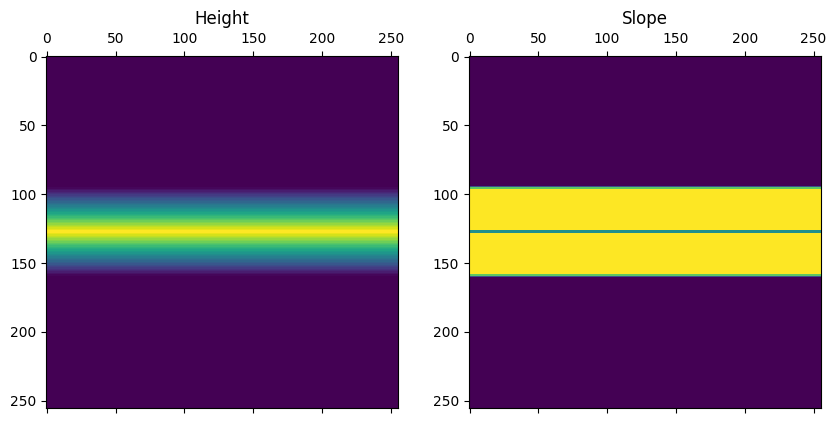

In [23]:
# An illustration of the environment
N = 256
height, slope = environment_2d(N, 'horizontal')
        
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].matshow(height)
ax[1].matshow(slope)
ax[0].set_title("Height")
ax[1].set_title("Slope")
plt.show()

In [24]:
#######################################################
#      simulate temperatures pre and post change      #
#######################################################
# parameters:
# alpha - temperature change 
# beta - different temp at hill top
# delta - change in temperature
# noise_strength_0 - controls climate variability
# noise_strength_1 - controls prediction error
# base - implicit parameter, base temperature, doesnt matter for computations, set to 20
#
# (x,y) a coordinate, x is north, y is east/west
# X0 = base - alpha * x - beta * height(x,y) + noise 
# X1 = X0 + delta + noise 


def temperatures_2d(alpha, beta, delta, noise_strength_0, noise_strength_1, height, N):
    # temperature pre change 
    X0 = np.repeat(np.arange(1, N + 1).reshape(N, 1), N, axis=1)/N # relative north south coordinate
    X0 = 20 + alpha*X0 - beta*height
    X0 = X0 + 2*noise_strength_0*np.random.uniform(size=[N,N])
    
    # temperature post change
    X1 = X0 + delta + 2*noise_strength_1*np.random.uniform(size=[N,N])
    
    return X0, X1

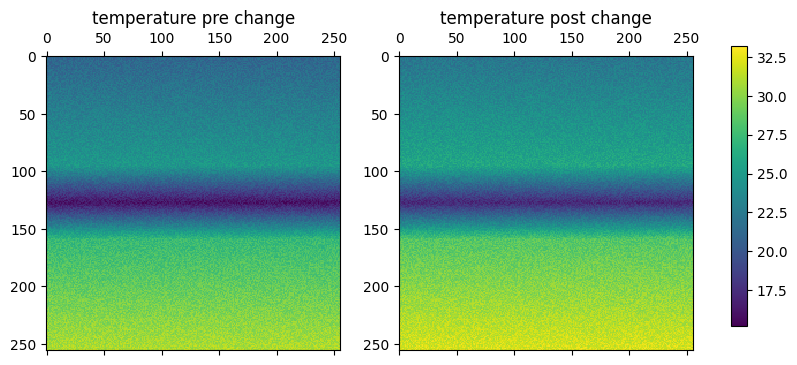

In [25]:
########################################################
#          generate temperatures and plot them         #
########################################################
alpha = 10
beta = 10
delta = 1
noise_strength_0 = 1
noise_strength_1 = 0.1

# environment and temperatures
N = 256
height, slope = environment_2d(N, 'horizontal')
X0, X1 = temperatures_2d(alpha, beta, delta, noise_strength_0, noise_strength_1, height, N)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Use shared color scale
vmin = min(X0.min(), X1.min())
vmax = max(X0.max(), X1.max())

im0 = ax[0].matshow(X0, vmin=vmin, vmax=vmax)
im1 = ax[1].matshow(X1, vmin=vmin, vmax=vmax)

ax[0].set_title("temperature pre change")
ax[1].set_title("temperature post change")

# Adjust layout to make room for colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space on the right

# Manually add colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im0, cax=cbar_ax)

plt.show()

In [9]:
#################################
# hierarchical search algorithm #
#################################

# max and min pooling layers
def max_pool(X):
    return X.reshape(X.shape[0]//2, 2, X.shape[1]//2, 2).max(axis=(1, 3))

def min_pool(X):
    return X.reshape(X.shape[0]//2, 2, X.shape[1]//2, 2).min(axis=(1, 3))

# build a hierarchy starting from X1
# apply max/min pooling iteratively
# importantly, X1 needs to be square with side length 2^m
def build_hierarchy(X1):
    k = int(np.log2(X1.shape[0]))  # depth of the hierarchy
    max_grids, min_grids = [X1], [X1]

    X = X1
    for _ in range(k):
        X = max_pool(X)
        max_grids.append(X)
    max_grids.reverse()

    X = X1
    for _ in range(k):
        X = min_pool(X)
        min_grids.append(X)
    min_grids.reverse()

    return min_grids, max_grids

# perform a hierachical seach to find all values in X1 that are x up to an error epsilon
# using the precomputed max/min grids
def hierarchical_search(X1, x, min_grids, max_grids, epsilon):
    N = len(min_grids)
    size = min_grids[0].shape[0]  # smallest (coarsest) grid

    results = []

    def recurse(level, i, j, i_base, j_base, scale):
        min_val = min_grids[level][i, j]
        max_val = max_grids[level][i, j]
        if x - epsilon > max_val or x + epsilon < min_val:
            return  # prune this region
        if level == N - 1:
            val = X1[i_base, j_base]
            if abs(val - x) < epsilon:
                results.append((i_base, j_base))
        else:
            for di in range(2):
                for dj in range(2):
                    recurse(
                        level + 1,
                        2 * i + di,
                        2 * j + dj,
                        i_base + di * scale // 2,
                        j_base + dj * scale // 2,
                        scale // 2
                    )

    # start from coarsest level
    for i in range(size):
        for j in range(size):
            recurse(0, i, j, i * 2**(N - 1), j * 2**(N - 1), 2**(N - 1))

    return results

# minimal euclidean distance between (i,j) and and array of indices
def min_l2_distance(index_array, i, j):
    if index_array:
        diffs = index_array - np.array([i, j])
        dists_squared = np.sum(diffs ** 2, axis=1)
        return np.sqrt(np.min(dists_squared))
    else:
        return -1
    
# compute climate distances
# precompute the grids for all points on the grid at once
# for each point, do a hierarchical search
# this prints updates
def climate_distance_hier(X0, X1, eps):
    # build grids
    min_grids, max_grids = build_hierarchy(X1)
    print('hierarchies computed')
    
    # size
    N = len(X0)
    D = np.zeros([N,N])
    
    # compute
    for i in range(N):
        for j in range(N):
            D[i,j] = min_l2_distance(hierarchical_search(X1, X0[i,j], min_grids, max_grids, eps), i, j)
            
        if i%10 == 0:
            print('row ' + str(i) + ' finished')
    
    # if no match is found, the distance is -1
    return D

In [10]:
#################################################
#         simulate climate distances            #
#################################################

####
# Parameters
####
alpha = 10
beta = 10
delta = 1
noise_strength_0 = 1
noise_strength_1 = 0.1

####
# Grid size
# Needs to be 2^m
####
N = 64

###
# environment and temperatures
###
height, slope = environment_2d(N, 'horizontal')
X0, X1 = temperatures_2d(alpha, beta, delta, noise_strength_0, noise_strength_1, height, N)

# start times
start = time.time()

# compute matrix of climate distances
D = climate_distance_hier(X0, X1, 0.2)

# stop timer and print computation time
end = time.time()
print(f"Elapsed time: {end - start:.4f} seconds")

# optional: save output
if False:
    np.savetxt("D.csv", D, delimiter=",")

hierarchies computed
row 0 finished
row 10 finished
row 20 finished
row 30 finished
row 40 finished
row 50 finished
row 60 finished
Elapsed time: 1.8626 seconds


In [13]:
# Some smoothing functions 

def gaussian_kernel(size, sigma):
    """Generate a 2D Gaussian kernel with given size and sigma."""
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

def smooth_matrix_gaussian(N, window_size=5, sigma=1.0):
    """Apply Gaussian smoothing to matrix N using only NumPy."""
    kernel = gaussian_kernel(window_size, sigma)
    pad = window_size // 2
    padded = np.pad(N, pad_width=pad, mode='edge')
    
    smoothed = np.zeros_like(N)
    for i in range(N.shape[0]):
        for j in range(N.shape[1]):
            window = padded[i:i+window_size, j:j+window_size]
            smoothed[i, j] = np.sum(window * kernel)
    
    return smoothed

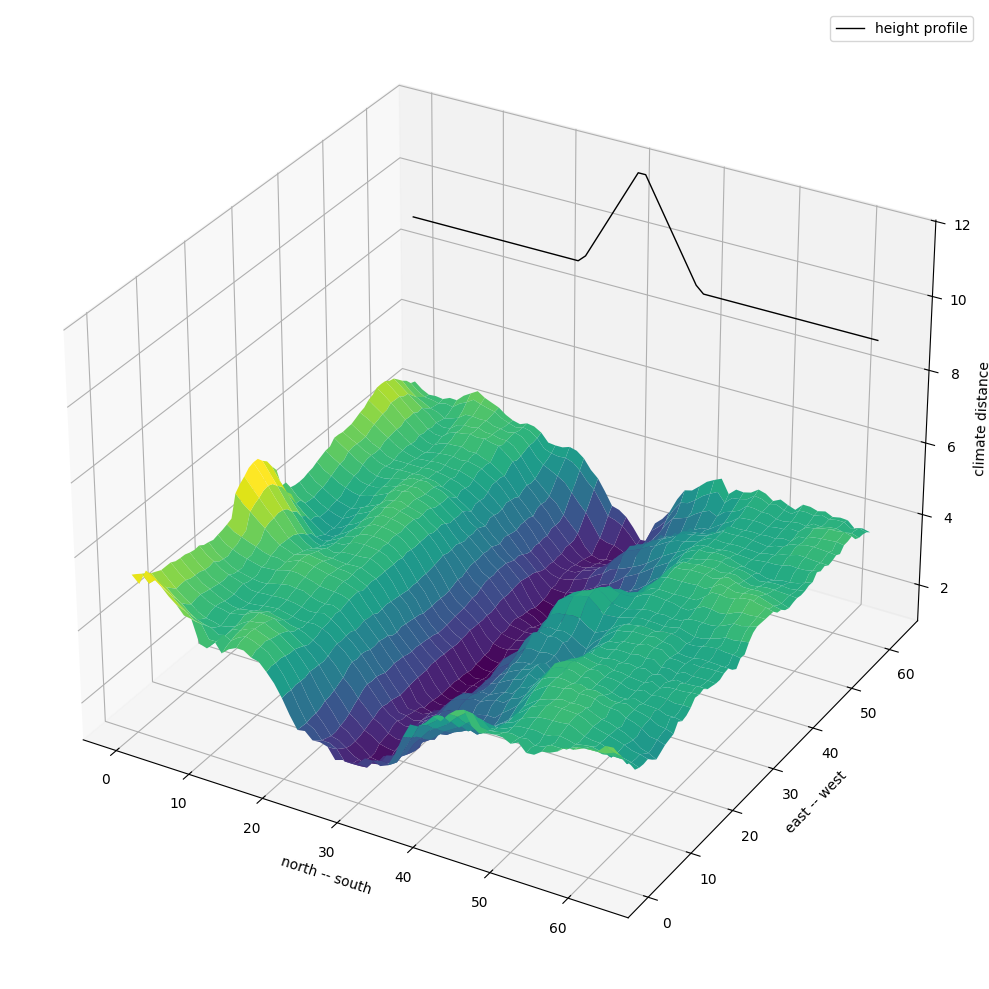

In [19]:
###########################################
#    surface plot of climate distances    #
###########################################
# It is recommended to truncate the plot to discard boundary effects
# Similarly, truncate very large climate distances
# Also, decide how to handle points where no match was founds

# truncate large distances & smooth the matrix
N = D.copy()
N[(N>20)] = 5 # truncate large climate distances
N = N[0:64, 0:64] # truncate matrix to get rid of boundary effects
N = smooth_matrix_gaussian(N, 10, 5)
N = N.transpose() # rotate 90 degrees
N[N<0] = 5  # for the points where no match was found

# height as 1d function
h = height[:,0]
h = 9+3*h[0:64]

# Create grid of x (columns) and y (rows)
x = np.arange(N.shape[1])
y = np.arange(N.shape[0])
X, Y = np.meshgrid(x, y) 

# Generate line at y = max(y)
x_line = x
y_line = np.full_like(x_line, y.max())  # place at "back"
z_line = h

# initialise the plot
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

# Plot the 1D line first, so it's "behind"
ax.plot(x_line, y_line, z_line, color='black', linewidth=1, label='height profile')

# Plot the surface
ax.plot_surface(X, Y, N, cmap='viridis')

ax.set_xlabel('north -- south')
ax.set_ylabel('east -- west')
ax.set_zlabel('climate distance')

# Optional legend
ax.legend()

plt.tight_layout()

# optional:save plot
if False:
    plt.savefig("CD_surface_512.png", dpi=400, bbox_inches='tight')
    
plt.show()

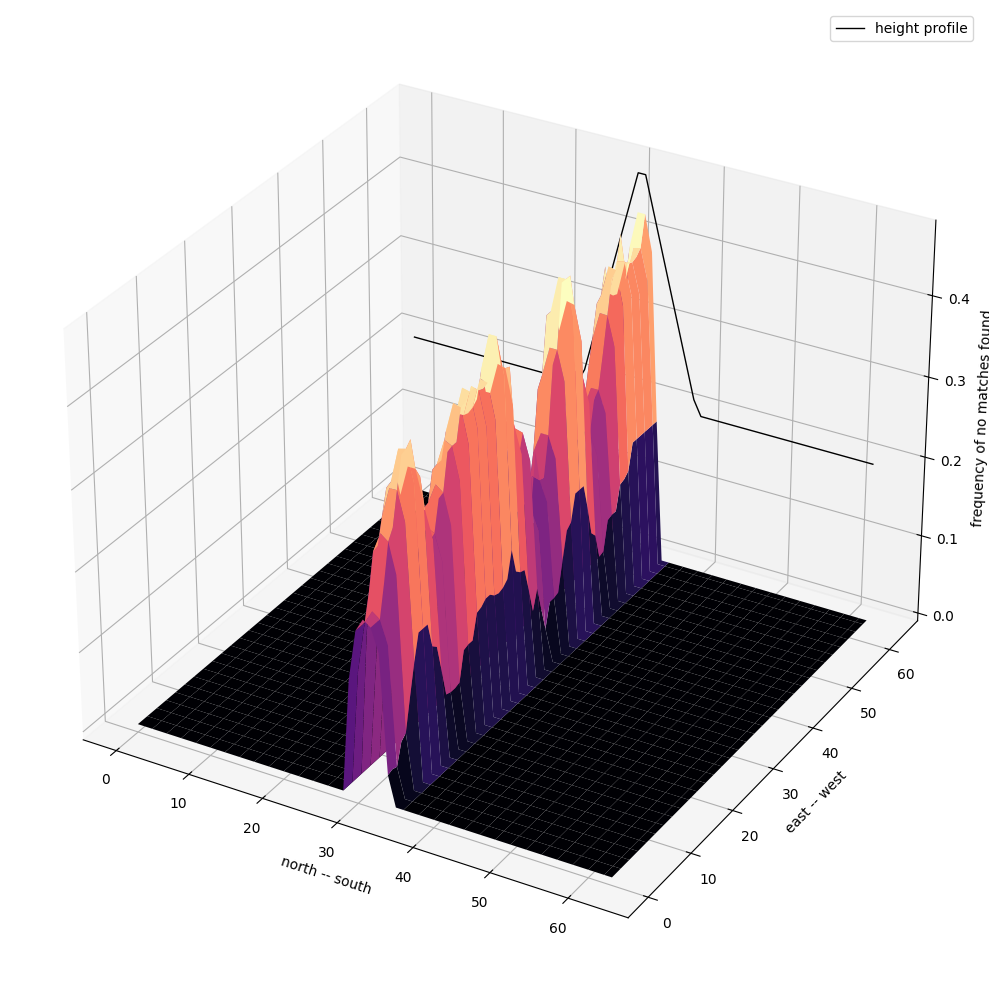

In [22]:
#### surface plot of no matches found

# truncate large distances & smooth the matrix
N = D.copy()
N = (N<0)
N = N.astype(float)
N = N[0:64, 0:64] # truncate matrix to get rid of boundary effects
N = smooth_matrix_gaussian(N, 5, 3)
N = N.transpose() # roate 90 degrees

# height as 1d function
h = height[:,0]
h = 0.2+0.3*h[0:64]

# Create grid of x (columns) and y (rows)
x = np.arange(N.shape[1])
y = np.arange(N.shape[0])
X, Y = np.meshgrid(x, y) 

# Generate line at y = max(y)
x_line = x
y_line = np.full_like(x_line, y.max())  # place at "back"
z_line = h

# initialise the plot
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

# Plot the 1D line first, so it's "behind"
ax.plot(x_line, y_line, z_line, color='black', linewidth=1, label='height profile')

# Plot the surface
ax.plot_surface(X, Y, N, cmap='magma')

# second plot for where the mountains are
#ax.plot_surface(X, Y, -G, cmap='viridis')

ax.set_xlabel('north -- south')
ax.set_ylabel('east -- west')
ax.set_zlabel('frequency of no matches found')

# Optional legend
ax.legend()
#ax.legend(loc='upper center', bbox_to_anchor=(4, 4))

plt.tight_layout()

# optional: save plot
if False:
    plt.savefig("CD_no_matches_512.png", dpi=400, bbox_inches='tight')

plt.show()

## 1D simulation

This is very similar to the 2d simulation. The main difference is that this is faster to simulate, so we can averge over multiple runs for large grids. This allows us to study the dependence on the threshold. 

In [30]:
######################################
#     generate height environment    #
#
# all environments are part of an interval of length N
# the max height of the hill is always 1
# w controls the width of the mountain range
######################################

def environment_1d(N = 50, w = 8):
    height = np.zeros(N)
    for i in range(N):
        height[i] = np.max([1-(w/N)*np.abs(i-N/2+0.5),0])
    
    dx = np.gradient(height)
    slope = np.abs(dx)
    
    return height, slope

In [31]:
###########
# simulate temperatures pre and post change
###########
# parameters:
# alpha - temperature change 
# beta - different temp at hill top
# delta - change in temperature
# noise_strength_0 - controls climate variability
# noise_strength_1 - controls prediction error
# base - implicit parameter, base temperature, doesnt matter for computations, set to 20
#
#
# x a coordinate, x is north
# X0 = base - alpha * x - beta * height(x) + noise 
# X1 = X0 + delta + noise 


def temperatures_1d(alpha, beta, delta, noise_strength_0, noise_strength_1, height, N):
    # temperature pre change 
    X0 = np.arange(0,N)/N
    X0 = 30 - alpha*X0 - beta*height
    X0 = X0 + 2*noise_strength_0*np.random.uniform(size=N)
    
    # temperature post change
    X1 = X0 + delta + 2*noise_strength_1*np.random.uniform(size=N)
    
    return X0, X1

In [36]:
###
# simple search algorithm thanks to 1d structure
###

def search_1d(X0, X1, i, eps):
    N = len(X0)
    
    for j in range(N):
        for k in [i+j, i-j]:
            if 0<= k < N:
                if abs(X1[k]-X0[i])<eps:
                    return j
            else:
                continue 
    return -1  # if no point found within max_radius
                
def climate_distance_1d(X0, X1, eps=1):
    D = np.zeros(N)
    for i in range(N):
        D[i] = search_1d(X0, X1, i, eps)
    return D

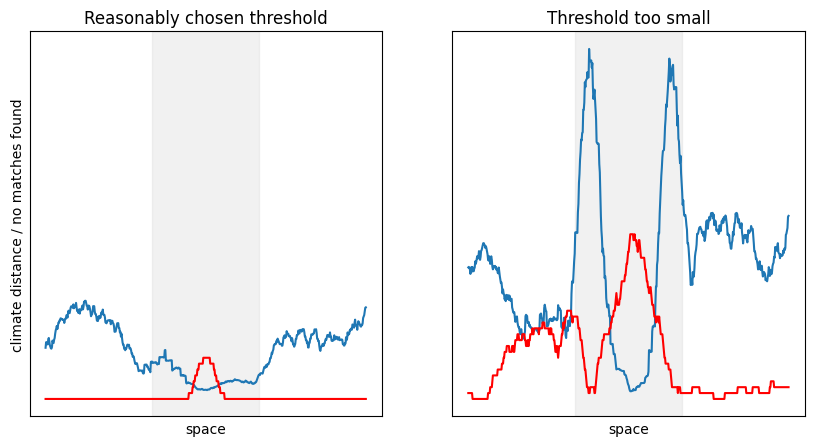

In [42]:
#######################################
#    Simulating 1D climate distance   #
#######################################


#############
# Parameters
#############
alpha = 10
beta = 10
delta = 1
noise_strength_0 = 1
noise_strength_1 = 0.1
N = 1000

### temperatures
height, slope = environment_1d(N, 10)
X0, X1 = temperatures_1d(alpha, beta, delta, noise_strength_0, noise_strength_1, height, N)

# thresholds
epsilons = [0.2, 0.02]  # 0.2 and 0.02 are good values for N=1000, alpha = 10, beta = 10, delta = 1
                        # noise_strength_0 = 1, noise_strength_1 = 0.2

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    # compute climate distances
    eps = epsilons[i]
    D = climate_distance_1d(X0, X1, eps)

    # average D locally - smoothing
    window_size = 40
    kernel = np.ones(window_size) / window_size
    D_avg = np.convolve(D, kernel, mode='same')

    # smooth the not-found
    no_match = np.convolve((D < 0) * 0.1, kernel, mode='same')

    # plot the smoothing
    ax[i].plot((D_avg / N)[200:800])
    ax[i].plot(no_match[200:800], color='red')

    # shade where the mountains are
    ax[i].axvspan(200, 400, color='lightgray', alpha=0.3)

    # Remove all ticks and labels
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].tick_params(axis='both', which='both', length=0)

    # Add x-axis label
    ax[i].set_xlabel('space')

# Set y-axis label on the first subplot
ax[0].set_ylabel('climate distance / no matches found')

# Set subplot titles
ax[0].set_title('Reasonably chosen threshold')
ax[1].set_title('Threshold too small')

# Match y-axis limits across subplots
ymins = [a.get_ylim()[0] for a in ax]
ymaxs = [a.get_ylim()[1] for a in ax]
shared_ymin = min(ymins)
shared_ymax = max(ymaxs)
for a in ax:
    a.set_ylim(shared_ymin, shared_ymax)

plt.show()

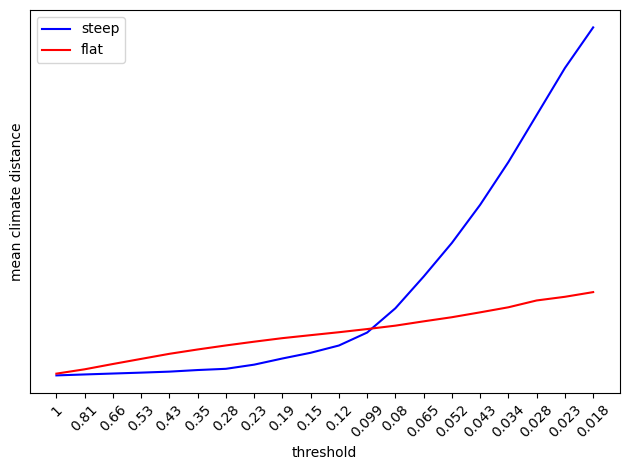

In [45]:
#########################################################
#   Dependence of the threshold on climate distance     #
#########################################################
# This reuses the parameters from the previous simulation

# number of different thresholds
k = 20
# number of runs to be averaged over 
m = 10 

epsilons = np.exp(-np.linspace(0,4,k))

steep_means = np.zeros([k,m])
flat_means = np.zeros([k,m])

for i in range(m):
    #sample new temperatures
    X0, X1 = temperatures_1d(alpha, beta, delta, noise_strength_0, noise_strength_1, height, N)
    
    for j in range(k):
        eps = epsilons[j]
        
        # calculate distance and remove the boundary
        D = climate_distance_1d(X0, X1, eps)

        # for steep locations, if no analogue if found, use the highest observed distance for other steep locations
        mask = (slope > 0) & (D < 0)
        D[mask] = np.max(D[slope > 0])

        # look at steep and flat locations
        steep_locs = slope>0
        flat_locs = ~steep_locs 

        # split the distances
        D_steep = D[steep_locs]

        # flat points without boundary
        mask_nb = np.zeros_like(slope, dtype=bool)
        mask_nb[100:900] = True #truncate boundary
        flat_mask = (slope == 0) & mask_nb

        # calculate mean for steep and flat
        steep_means[j,i] = np.mean(D_steep)
        flat_means[j,i] = np.mean(D[flat_mask])
        
# take means for each epsilon over the different runs
steep_means = np.mean(steep_means, axis=1)
flat_means = np.mean(flat_means, axis=1)

# Plotting the means
x_vals = -np.log(epsilons)

plt.plot(x_vals, steep_means, color='blue', label='steep')
plt.plot(x_vals, flat_means, color='red', label='flat')

plt.legend()
plt.xlabel('threshold')
plt.ylabel('mean climate distance')

# Set x-ticks at the transformed -log(epsilon) values
plt.xticks(ticks=x_vals, labels=[f'{e:.2g}' for e in epsilons], rotation=45)

plt.yticks([])

plt.tight_layout()
plt.show()